# Capstone Project - Battle of the Neighborhoods (Week - 1)
### Applied Data Science Capstone by IBM/Coursera

# Predicting Covid Intensive Zones in Delhi

## Table of contents
* [Introduction: Business Problem](#intro)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction/Business Problem <a name="intro"></a>

Covid-19 is an infectious disease that has caused a havoc in the modern world by disrupting the daily life of every civilian on earth. The virus which primarily affects the lungs, has infected 4,543,390 people globally and 303,711 people have lost their lives because of it (as of 15th May, 2020). The pandemic has forced world leaders to come up with stringent measures such as nation-wide lockdowns to curb the spread of the virus. But lockdowns are holding back civilians from working and earning a living, and its effect does not trouble the poor but every section of the society, even the governments themselves. In such a situation, where economies fall and countries will be heading to recessions, people might be forced to head out and work and live along with the virus. 
This causes a huge risk to countries like mine, India, with an enormous population density.   
To forsee the effects of lifting lockdowns, my research and this notebook will help people understand which neighborhoods might see a surge in Covid-19 cases. I will be using population density data and location data of popular venues, their proximity and their frequency of occurence  (like popular market places) to estimate the interaction occuring at a particular place. I will be focusing on the predictions mainly in my city (Delhi, the capital of India).  
With this, I hope readers can better understand potentially risky areas and authorities can take measures to place restrictions beforehand to such areas to reduce the spread of the virus and thus the suffering to civilian life.  
I hope and pray whoever reads this is safe.

## Data <a name="data"></a>

To solve the above problem, I have made use of the following data:
* Neighborhoods of Delhi (and the basis of their segmentation) - https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi  
There are 9 districts in delhi and the neighborhoods are aggregated into one of these districts.  
This data would be used to define the neighborhoods when I will be plotting the results on the map.
I used the help of the 'search' option in Google Maps to figure out the approximate coordinates of each neighborhood and created my own dataset.
     
     
* Location data of popular venues - provided by Foursquare API  
The Foursquare API provides data related to the frequency of occurence of different venues at a particular place.  
I will be using the location data to identify clusters where proximity of venues with high footfall (like markets) are present.  
These will be identified as hotspot heighborhoods.


* Population density of various districts - Census 2011 data - https://www.census2011.co.in/census/state/districtlist/delhi.html  
The population density data would be used to mark districts with potentially high risk of community transmission due to the high proximity in living conditions.


### Let's get these datasets

In [18]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium

In [22]:
url = 'https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi'
html_content = requests.get(url).text

soup = BeautifulSoup(html_content, "html.parser")

In [23]:
delhi_table = soup.find_all("span",attrs={"class":"mw-headline"})
districts = []
i=1;
for v in delhi_table:
    districts.append(v.text)
    i=i+1
    if(i==10):
        break

In [24]:
districts

['North West Delhi',
 'North Delhi',
 'North East Delhi',
 'Central Delhi',
 'New Delhi',
 'East Delhi',
 'South Delhi',
 'South West Delhi',
 'West Delhi']

##### **Please note this data is according to Census 2011 which declares 9 districts as opposed to 11 districts as per the current situation**.
##### **Therefore, we will be adding places in SOUTH EAST DELHI under SOUTH DELHI and places in SHAHDARA under EAST DELHI.**

In [25]:
address = 'Delhi, India'

geolocator = Nominatim(user_agent="del_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Delhi are 28.6517178, 77.2219388.


#### Loading the Dataset I created onto my IBM Watson Studio Notebook

In [27]:
df_delhi = pd.read_excel('Delhi_Neigh_LatLong.xlsx')
df_delhi.head()

,District,Neighborhood,Latitude,Longitude
0,North West Delhi,Adarsh Nagar,28.719390,77.173270
1,North West Delhi,Ashok Vihar,28.687260,77.177689
2,North West Delhi,Azadpur,28.712997,77.177360
3,North West Delhi,Bawana,28.797247,77.048331
4,North West Delhi,Begum Pur,28.726457,77.064246


In [28]:
df_delhi.shape

(175, 4)

In [29]:
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, dist, neighborhood in zip(df_delhi['Latitude'], df_delhi['Longitude'], df_delhi['District'], df_delhi['Neighborhood']):
    label = '{}, {}'.format(neighborhood, dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

#### Let us now get the venues in each neighborhood

In [30]:
CLIENT_ID = 'Y3H35IKOA5URAE5CNY0CN5UACSA4BIVGWAPYFZ1TYQGOB435'
CLIENT_SECRET = 'F0LOPS1EHYFZPIC3I5OSQ2FMOVN0CHA5VIQ3SRDMLYHZQW1E'
VERSION = '20200511' 
LIMIT = 50
radius = 1000

In [31]:
# Function for getting venues by the neighborhood, latitiute, longitude and radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [101]:
delhi_venues = getNearbyVenues(names=df_delhi['Neighborhood'],
                                   latitudes=df_delhi['Latitude'],
                                   longitudes=df_delhi['Longitude']
                                  )


Naraina
Palam
Rama Krishna Puram
Rajokri
Rangpuri
Sagar Pur
Vasant Kunj
Vasant Kunj Mall Road
Vasant Vihar
Ashok Nagar
Bali Nagar
Fateh Nagar
Janakpuri
Kirti Nagar
Meera Bagh
Moti Nagar
Partap Nagar
Paschim Vihar
Patel Nagar
Punjabi Bagh
Rajouri Garden
Shivaji Place
Tihar Village
Tilak Nagar
Uttam Nagar
Vikas Nagar
Vikaspuri


In [33]:
delhi_venues.shape

(1247, 7)

In [34]:
delhi_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,28.71939,77.173270,My Idea Store,28.717487,77.170922,Mobile Phone Shop
1,Adarsh Nagar,28.71939,77.173270,Pahalwan Vaishno Dhaba,28.715881,77.173565,North Indian Restaurant
2,Adarsh Nagar,28.71939,77.173270,Adarsh Nagar Metro Station,28.716598,77.170436,Light Rail Station
3,Adarsh Nagar,28.71939,77.173270,Vishyavidyalaya Metro Station@Entry gate #1 n ...,28.715596,77.170981,Train Station
4,Ashok Vihar,28.68726,77.177689,Mirch te Masala,28.687374,77.173744,Mughlai Restaurant


Lets see the number of venues returned per neighborhood

In [35]:
delhi_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adarsh Nagar,4,4,4,4,4,4
Alaknanda,7,7,7,7,7,7
Ashok Nagar,4,4,4,4,4,4
Ashok Vihar,4,4,4,4,4,4
Azadpur,3,3,3,3,3,3
...,...,...,...,...,...,...
Vasundhara Enclave,4,4,4,4,4,4
Vikaspuri,4,4,4,4,4,4
Vishwas Nagar,4,4,4,4,4,4


##### We see that only 161 neighborhoods were returned. This means that out of 177 neighborhoods, 16 had no venue results.  

In [36]:
print('There are {} unique venue categories.'.format(len(delhi_venues['Venue Category'].unique())))

There are 174 unique venue categories.


#### Checking for misleading Venue Category name

In [37]:
conflicting_value = delhi_venues[delhi_venues['Venue Category']=='Neighborhood']
conflicting_value

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
815,Maharani Bagh,28.573481,77.263217,Maharani Bagh,28.573519,77.260392,Neighborhood


##### We see that Venue Category has a value 'Neighborhood' which can be misleading since one of our column names is also Neighborhood.¶
##### Hereafter, we will name the column 'Neighborhoods', to avoid the confusion

In [38]:
map_delhi_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, ven, cat in zip(delhi_venues['Venue Latitude'], delhi_venues['Venue Longitude'], delhi_venues['Venue'], delhi_venues['Venue Category']):
    label = '{}, {}'.format(ven,cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi_venues)  
    
map_delhi_venues

###### It is noted that Foursquare API doesnt have much details reagrding venues in Delhi, therefore this is just an approximate picture of the real world. But we can surely say that it is a good approximation and will serve our need.

### Now lets scrape the district-wise population density data

In [40]:
url = 'https://www.census2011.co.in/census/state/districtlist/delhi.html'
html_content = requests.get(url).text

soup = BeautifulSoup(html_content, "html.parser")

In [41]:
density_t = soup.find("table")
density_headings = density_t.find_all("th")
den_headings = []
for v in density_headings:
    den_headings.append(v.text)

In [107]:
delhi_table_data = density_t.find_all("tr")
table_data = []
for v in delhi_table_data:
    if(v!=delhi_table_data[0]):
        t_row = {}
        for td,h in zip(v.find_all("td"),den_headings):
            t_row[h] = td.text.replace('\n', '').strip()
        table_data.append(t_row)

In [108]:
den_delhi = pd.DataFrame(table_data)
den_delhi

,#,District,Sub-Districts,Population,Increase,Sex Ratio,Literacy,Density
0,1,North West Delhi,List,"3,656,539",27.81 %,865,84.45 %,8254
1,2,South Delhi,List,"2,731,929",20.51 %,862,86.57 %,11060
2,3,West Delhi,List,"2,543,243",19.46 %,875,86.98 %,19563
3,4,South West Delhi,List,"2,292,958",30.65 %,840,88.28 %,5446
4,5,North East Delhi,List,"2,241,624",26.78 %,886,83.09 %,36155
5,6,East Delhi,List,"1,709,346",16.79 %,884,89.31 %,27132
6,7,North Delhi,List,"887,978",13.62 %,869,86.85 %,14557
7,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,Central Delhi,List,"582,320",-9.91 %,892,85.14 %,27730
9,9,New Delhi,List,"142,004",-20.72 %,822,88.34 %,4057


Dropping the row with the google advertisement info. Also, we just want the district-wise population density data so we drop the other columns.

In [109]:
den_delhi.dropna(inplace=True)

In [110]:
den_delhi = pd.DataFrame(den_delhi[['District','Density']])
den_delhi

,District,Density
0,North West Delhi,8254
1,South Delhi,11060
2,West Delhi,19563
3,South West Delhi,5446
4,North East Delhi,36155
5,East Delhi,27132
6,North Delhi,14557
8,Central Delhi,27730
9,New Delhi,4057


#### As per our assumption lets add districts SOUTH EAST DELHI and SHAHDARA with density population equal to SOUTH DELHI and EAST DELHI resp 

In [111]:
new_districts = pd.DataFrame({"District":['South East Delhi','Shahdara'],"Density":[11060,27132]})
den_delhi = den_delhi.append(new_districts)
den_delhi.reset_index(inplace = True, drop = True) 

In [112]:
den_delhi

,District,Density
0,North West Delhi,8254
1,South Delhi,11060
2,West Delhi,19563
3,South West Delhi,5446
4,North East Delhi,36155
5,East Delhi,27132
6,North Delhi,14557
7,Central Delhi,27730
8,New Delhi,4057
9,South East Delhi,11060


## Methodology <a name="methodology"></a>

To predict the Covid Intensive Zones in Delhi, we shall perform the following steps:
* Find the popular venue categories of each neighborhood
* Form clusters of the neighborhoods according the prevalent venue categories using '**KMeans Clustering**'
* Superimpose a layer of chloropleth map of the population densities in each dsitrict to rightly predict the severity of the possible situation

## Analysis <a name="analysis"></a>

First, we shall be producing a Data Frame containing 1/0 (ie Yes/No) values for all venue category with respect to each venue. This process is called one-hot encoding.

In [46]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot.insert(0, 'Neighborhoods',delhi_venues['Neighborhood'])

delhi_onehot.head()

,Neighborhoods,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Women's Store
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Ashok Vihar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lets group and normalize this data

In [47]:
delhi_grouped = delhi_onehot.groupby('Neighborhoods').mean().reset_index()

#### Now we find the top 2 venue categories in each venue

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 2

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = delhi_grouped['Neighborhoods']

for ind in np.arange(delhi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue
0,Adarsh Nagar,Train Station,North Indian Restaurant
1,Alaknanda,BBQ Joint,Food & Drink Shop
2,Ashok Nagar,Fast Food Restaurant,North Indian Restaurant
3,Ashok Vihar,Indian Restaurant,Garden
4,Azadpur,Park,North Indian Restaurant


### It is time for Clustering!

In [50]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

First, let us find the optimum value of **K** by **Silhoutte Score Comparison**

In [51]:
delhi_grouped_clustering = delhi_grouped.drop('Neighborhoods', 1)

In [410]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(delhi_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(delhi_grouped_clustering, labels, metric = 'euclidean'))

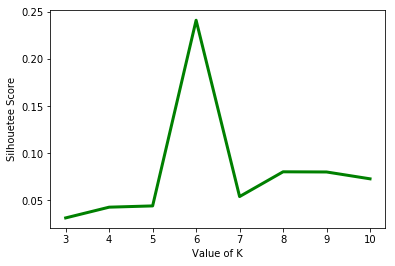

In [411]:
plt.plot(range(3, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouetee Score") 
plt.show() # clear the plot 

We see that **K = 6** yields the best result

In [52]:
kclusters = 6

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

kmeans.labels_

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kmeans.labels_[0:10] 

array([2, 2, 1, 3, 1, 1, 3, 2, 2, 2], dtype=int32)

In [53]:
# Creating a dataframe with venues and respective cluster groups

# lets first change the name of the' Neighborhood' column in df_toronto to 'Neighborhoods'
df_delhi.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

#Merging
delhi_merged = df_delhi
delhi_merged = delhi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhoods')

delhi_merged.head() 

,District,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
0,North West Delhi,Adarsh Nagar,28.719390,77.173270,2.0,Train Station,North Indian Restaurant
1,North West Delhi,Ashok Vihar,28.687260,77.177689,3.0,Indian Restaurant,Garden
2,North West Delhi,Azadpur,28.712997,77.177360,1.0,Park,North Indian Restaurant
3,North West Delhi,Bawana,28.797247,77.048331,5.0,Accessories Store,Women's Store
4,North West Delhi,Begum Pur,28.726457,77.064246,5.0,Accessories Store,Women's Store


#### Lets drop the neighborhoods with no venue results

In [54]:
delhi_merged.dropna(inplace=True)
delhi_merged.reset_index(inplace = True, drop = True)

Now convert the **Cluster Labels** column to **int**

In [55]:
delhi_merged['Cluster Labels'] = pd.to_numeric(delhi_merged['Cluster Labels'], downcast='integer')

In [56]:
delhi_merged.shape

(161, 7)

In [57]:
delhi_merged.head()

,District,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
0,North West Delhi,Adarsh Nagar,28.719390,77.173270,2,Train Station,North Indian Restaurant
1,North West Delhi,Ashok Vihar,28.687260,77.177689,3,Indian Restaurant,Garden
2,North West Delhi,Azadpur,28.712997,77.177360,1,Park,North Indian Restaurant
3,North West Delhi,Bawana,28.797247,77.048331,5,Accessories Store,Women's Store
4,North West Delhi,Begum Pur,28.726457,77.064246,5,Accessories Store,Women's Store


### Finally, let us create the Map

In [58]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [122]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['yellow','blue','purple','red','turquoise','green']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['Latitude'], delhi_merged['Longitude'], delhi_merged['Neighborhoods'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Legend
* Most Concerning - RED, YELLOW
* Moderately Concerning - PURPLE, BLUE
* Least Corcerning - TURQUOISE
* Not Concerning - GREEN

### Let us look at these clusters in detail

##### Neighborhoods predominantly having 'Fast Food Restaurants' and other socially active places. (Most Concerning) - YELLOW MARKER

In [60]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue
10,Model Town,Donut Shop,Chinese Restaurant
15,Chawri Bazaar,Fast Food Restaurant,Hardware Store
19,Kamla Nagar,Breakfast Spot,Fast Food Restaurant
20,Kashmiri Gate,Pizza Place,American Restaurant
25,Pul Bangash,Indian Restaurant,Metro Station
26,Roshanara Bagh,Restaurant,Metro Station
52,Rajender Nagar,Fast Food Restaurant,Sandwich Place
64,Krishna Nagar,Fast Food Restaurant,Department Store
65,Laxmi Nagar,Warehouse Store,Fast Food Restaurant
80,Dayanand Colony,Restaurant,Indie Movie Theater


##### Neighborhoods with housing complexes and normal day-to-day civilian acitivies. (Moderately Concerning) - BLUE MARKER

In [61]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue
2,Azadpur,Park,North Indian Restaurant
35,Babarpur,Park,Gift Shop
37,Kabir Nagar,Motorcycle Shop,Park
45,Shastri Park,Metro Station,Women's Store
48,Jhandewalan,Light Rail Station,Gift Shop
74,Vishwas Nagar,Big Box Store,Hotel
87,Hauz Khas,Dessert Shop,Café
103,Neeti Bagh,Café,Dessert Shop
105,Netaji Nagar,Hotel,Café
106,New Friends Colony,Chinese Restaurant,Hotel


##### Neighborhoods with many daily life associated venues. (Moderately Concerning) - PURPLE MARKER

In [62]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 2, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue
0,Adarsh Nagar,Train Station,North Indian Restaurant
6,Jahangirpuri,IT Services,Women's Store
7,Keshav Puram,Shopping Mall,Bakery
8,Kingsway Camp,Snack Place,Shopping Mall
11,Pitam Pura,Gym,Fast Food Restaurant
...,...,...,...
142,Vasant Kunj Mall Road,Coffee Shop,Café
145,Bali Nagar,Pizza Place,Convenience Store
150,Moti Nagar,Ice Cream Shop,Fried Chicken Joint
153,Patel Nagar,Light Rail Station,Hotel


##### Neighborhoods with 'Indian Restaurants' predominant. (Most Concerning) - RED MARKER

In [63]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 3, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue
1,Ashok Vihar,Indian Restaurant,Garden
5,Dhaka,Indian Restaurant,Train Station
9,Kohat Enclave,Indian Restaurant,Light Rail Station
12,Rani Bagh,Indian Restaurant,Convenience Store
14,Shalimar Bagh,Indian Restaurant,Restaurant
16,Civil Lines,Indian Restaurant,Chinese Restaurant
17,Dariba Kalan,Indian Restaurant,Snack Place
18,Ghantewala,Indian Restaurant,Park
21,Kotwali,Indian Restaurant,Market
29,Sarai Kale Khan,Indian Restaurant,Art Gallery


##### Neighborhoods with venues of essentials only. (Least Concerning) - TURQUOISE MARKER

In [64]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 4, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue
34,Wazirabad,ATM,Fast Food Restaurant
39,Maujpur,ATM,Fast Food Restaurant
41,Nand Nagri,ATM,Fast Food Restaurant
43,New Usmanpur,ATM,Food Truck
44,Sadatpur,ATM,Motorcycle Shop
66,Mayur Vihar,ATM,Bank
113,Sangam Vihar,ATM,Athletics & Sports
122,Tughlaqabad,ATM,Fast Food Restaurant
139,Rajokri,ATM,Fast Food Restaurant
159,Uttam Nagar,ATM,Train Station


##### Neighborhoods with very few venues only. (Not Concerning) - GREEN MARKER

In [65]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 5, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue
3,Bawana,Accessories Store,Women's Store
4,Begum Pur,Accessories Store,Women's Store


### Now let us add a layer of distinction of district-wise density population

In [117]:
delhi_geo = r'delhi_districts.json' # geojson file

# create a plain world map
delhi_dis_map = folium.Map(location=[latitude, longitude], zoom_start=10)

In [118]:
den_delhi['Density'] = pd.to_numeric(den_delhi['Density'], downcast='integer')
den_delhi.dtypes

District    object
Density      int32
dtype: object

In [120]:
threshold_scale = np.linspace(den_delhi['Density'].min(),
                              den_delhi['Density'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1

delhi_dis_map.choropleth(
    geo_data=delhi_geo,
    data=den_delhi,
    columns=['District', 'Density'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    threshold_scale=threshold_scale,
    fill_opacity=0.55, 
    line_opacity=0.2,
    legend_name='Population Density'
)

# display map
delhi_dis_map

### Finally lets superimpose this district-wise demarcation over our clustered neighborhoods map

In [123]:
for lat, lon, poi, cluster in zip(delhi_merged['Latitude'], delhi_merged['Longitude'], delhi_merged['Neighborhoods'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(delhi_dis_map)
       
delhi_dis_map

## Results and Discussion <a name="results"></a>

With the help of the final map, we can see which all districts are vulnerable to the spread of the virus and also which neighborhoods in the each district needs to be taken special take of.  
Places with Red and Yellow markers (Most Concerning zones) especially in districts like North East Delhi, North Delhi and Central can aggravate the situation if timely action is not taken.  
South West Delhi and North Delhi being a sparsely populated region should be the least concerning area in Delhi.  

The following improvements could be worked upon in future studies:  
* As mentioned earlier, Foursquare API doesn't provide very detailed results when used for collecting data about Delhi. Other Location Data providers could be utilized in further studies to result in more accuracy.  
* Furthermore, rather than working with coordinates of neighborhoods, if neighborhood boundaries could be utilized and all venues within the boundary is extracted, it would produce near perfect results.  
* Census 2011's data was used in this project. The current year is 2020 which we could mean the statistics could be changed a lot. So working with the latest Census, as and when it is released could better the results.

## Conclusion <a name="conclusion"></a>

Covid-19 has wreaked havoc all around the globe and almost half of the year has been now spent by all the people on earth in just fighting off the pandemic. With better strategies and more efficient systems we should tackle this problem so as to be done with it as soon as possible for not just the health of all the people but also for the falling economies.  
I hope this project of mine aids in the formation of mitigation strategies so that we all could win this battle and return to our normal lives at the earliest.  

I would like to thank **Coursera**, **IBM** and all the **faculties** involved with the **Data Science Professional Certificate Courses** for introducing me to Data Science and enabling me with all the skills required to conduct the analysis of the problem at hand and reach my results.
Last but not the least, I hope and pray my readers are safe.

Thank you for spending your valuable time in going through my work.